In [61]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

### **Clustering**

In [73]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(customer_info_preproc)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\vic\AppData\Local\Temp\ipykernel_36444\2766612558.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP1', y='UMAP2', data=embeddings_df, palette='tab10')


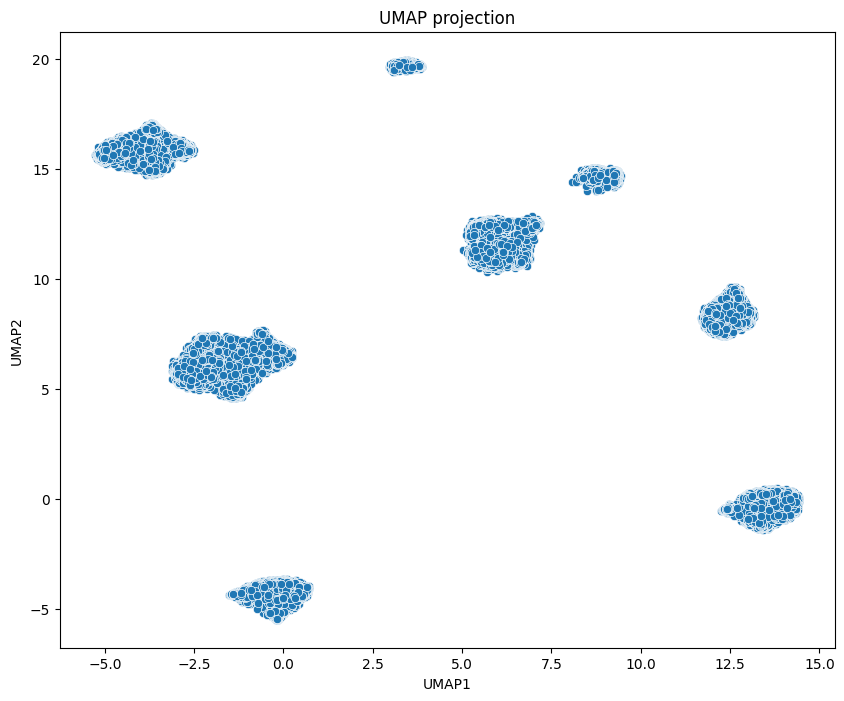

In [75]:
embeddings_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', data=embeddings_df, palette='tab10')
plt.title('UMAP projection')
plt.show()

In [ ]:
hdbscan = HDBSCAN(min_cluster_size=150, min_samples=10, cluster_selection_epsilon=1.4)
hdbscan_labels = hdbscan.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc.index)
umap_df['cluster'] = hdbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

### **Exporting the Clusters**

In [28]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))
fishy_outliers = pd.read_csv(os.path.join(base_dir, 'fishy_outliers.csv'), index_col='customer_id')

fishy_outliers['cluster'] = (max(umap_df['cluster']) + 1) * np.ones(fishy_outliers.shape[0])

In [65]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw/'))
customer_info = pd.read_csv(os.path.join(base_dir, 'customer_info.csv'), index_col='customer_id')

customer_info_clean = clean_customer_data(customer_info)

customer_info_clean = feat_engineering(customer_info_clean)

customer_info_clean_labeled = pd.merge(customer_info_clean, umap_df['cluster'], how='left', on='customer_id')

# merge fishy_outliers and fill missing clusters with the information from fishy_outliers
customer_info_clean_labeled = pd.merge(customer_info_clean_labeled, fishy_outliers[['cluster']], how='left', on='customer_id', suffixes=('', '_fishy'))

# combine cluster labels
customer_info_clean_labeled['cluster'] = customer_info_clean_labeled['cluster'].combine_first(customer_info_clean_labeled['cluster_fishy'])

customer_info_clean_labeled.drop(columns=['cluster_fishy'], inplace=True)

export_clusters(customer_info_clean_labeled, 'cluster')

## **Visualizing the Clusters**

In [69]:
customer_info_clean_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43631 entries, 39634 to 5120
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                43107 non-null  float64
 1   teens_home                               42610 non-null  float64
 2   number_complaints                        42977 non-null  float64
 3   distinct_stores_visited                  42322 non-null  float64
 4   spend_groceries                          43631 non-null  float64
 5   spend_electronics                        43631 non-null  float64
 6   typical_hour                             41886 non-null  float64
 7   spend_vegetables                         42758 non-null  float64
 8   spend_nonalcohol_drinks                  43631 non-null  float64
 9   spend_alcohol_drinks                     43631 non-null  float64
 10  spend_meat                               43

In [72]:
# statistics by cluster
spend_cols = ['spend_groceries', 'spend_electronics', 'spend_vegetables', 
                  'spend_nonalcohol_drinks', 'spend_alcohol_drinks', 'spend_meat', 
                  'spend_fish', 'spend_hygiene', 'spend_videogames', 'spend_petfood']

customer_info_clean_labeled.drop(columns=spend_cols, axis=1).groupby('cluster').mean().T

cluster                                          0.0           1.0  \
kids_home                                   0.663839      0.000000   
teens_home                                  0.932116      0.011813   
number_complaints                           0.913316      0.505271   
distinct_stores_visited                     2.716453      1.000000   
typical_hour                               12.706761     11.858968   
total_distinct_products                   408.123998     51.709502   
percentage_of_products_bought_promotion     0.398880      0.197791   
age                                        54.715707     54.771752   
loyalty_member                              0.668171      0.199953   
years_as_customer                          12.856011     12.946475   
educ_years                                 12.520774     12.000000   
gender_binary                               0.501244      0.494223   
frequency                                   2.257761      0.000000   
monetary                                 5846.975127  21527.461448   
spend_groceries_proportion                  0.342804      0.460985   
spend_electronics_proportion                0.050272      0.007844   
spend_vegetables_proportion                 0.051642      0.009832   
spend_nonalcohol_drinks_proportion          0.061877      0.024579   
spend_alcohol_drinks_proportion             0.066834      0.001982   
spend_meat_proportion                       0.077890      0.009969   
spend_fish_proportion                       0.089089      0.010014   
spend_hygiene_proportion                    0.089132      0.003899   
spend_videogames_proportion                 0.072591      0.000000   
spend_petfood_proportion                    0.101555      0.471413   

cluster                                          2.0          3.0  \
kids_home                                   0.317723     1.003143   
teens_home                                  0.016744     0.417716   
number_complaints                           0.011101     0.511318   
distinct_stores_visited                     1.390858     1.162064   
typical_hour                               18.862949    13.727487   
total_distinct_products                    55.271571   201.847587   
percentage_of_products_bought_promotion     0.107605     0.201344   
age                                        23.475931    54.425487   
loyalty_member                              0.499546     0.498589   
years_as_customer                           2.228883    12.914056   
educ_years                                 12.279746    14.096952   
gender_binary                               0.511353     0.495202   
frequency                                   2.295186     2.303556   
monetary                                 5309.672116  6054.738357   
spend_groceries_proportion                  0.165117     0.501788   
spend_electronics_proportion                0.098083     0.065785   
spend_vegetables_proportion                 0.018688     0.165059   
spend_nonalcohol_drinks_proportion          0.099694     0.050084   
spend_alcohol_drinks_proportion             0.365860     0.019608   
spend_meat_proportion                       0.035841     0.000273   
spend_fish_proportion                       0.037052     0.000230   
spend_hygiene_proportion                    0.099604     0.082832   
spend_videogames_proportion                 0.060168     0.033761   
spend_petfood_proportion                    0.020972     0.083940   

cluster                                           4.0           5.0  \
kids_home                                    1.001972      0.996328   
teens_home                                   0.996371      0.821111   
number_complaints                            0.500540      1.002459   
distinct_stores_visited                      1.388473      2.011468   
typical_hour                                13.642039      9.482962   
total_distinct_products                    100.584899   1058.570216   
percentage_of_products_bou

In [43]:
customer_info_clean_labeled_location = pd.merge(customer_info_clean_labeled, customer_info[['latitude', 'longitude']], how='left', on='customer_id')

plot_cluster(customer_info_clean_labeled_location, 4)